# JobInterviewGuide_Workshop

_Generated on: **2025-10-17T17:13:56**_

**Personalized focus (missed quiz items):**
1) **KNN Bias–Variance Tradeoff** (Q7)
2) **Cross-Entropy (Log Loss) in Logistic Regression** (Q10)
3) **Interpreting Linear Regression Coefficients** (Q12)
4) **KNN Hyperparameters Deep-Dive** (Q14)

**How to use this notebook**
- Read the short recap in each section.
- Complete the **TODO** scaffolds.
- Run the **sanity checks**.
- Finish with the **Reflection** to cement learning.


## 0) Setup
We use standard Python ML libraries.

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, f1_score, log_loss,
    mean_squared_error, r2_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
import time

np.random.seed(42)
print('The setup is complete.')


The setup is complete.


## 1) KNN Bias–Variance Tradeoff (Missed Q7)

**Recap.** Small `k` → low bias & high variance; Large `k` → higher bias & lower variance.

**Goal.** Train KNN across a range of `k` and compare train vs validation performance to visualize the tradeoff.


In [31]:
# TODO 1.1: Create non-linear data and split (60/20/20)
X, y = make_moons(n_samples=800, noise=0.3, random_state=42)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)
X_test_s  = scaler.transform(X_test)
X_train_s.shape, X_valid_s.shape, X_test_s.shape


((480, 2), (160, 2), (160, 2))

In [32]:
# TODO 1.2: Train KNN for k=1..40; record train/valid accuracy
k_values = list(range(1, 41))
rows = []
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_s, y_train)
    rows.append({
        'k': k,
        'train_acc': accuracy_score(y_train, model.predict(X_train_s)),
        'valid_acc': accuracy_score(y_valid, model.predict(X_valid_s))
    })
knn_df = pd.DataFrame(rows)
knn_df.head()


c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:189: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:189: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

,k,train_acc,valid_acc
0,1,1.000000,0.9000
1,2,0.929167,0.8625
2,3,0.933333,0.9250
3,4,0.920833,0.9375
4,5,0.918750,0.9375


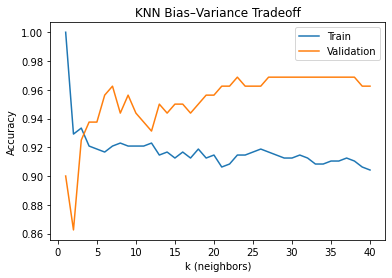

In [33]:
# TODO 1.3: Plot train vs validation accuracy vs k
plt.figure()
plt.plot(knn_df['k'], knn_df['train_acc'], label='Train')
plt.plot(knn_df['k'], knn_df['valid_acc'], label='Validation')
plt.xlabel('k (neighbors)')
plt.ylabel('Accuracy')
plt.title('KNN Bias–Variance Tradeoff')
plt.legend()
plt.show()


In [34]:
# Sanity check 1.4: choose best k by validation, evaluate on test
best_k = int(knn_df.loc[knn_df['valid_acc'].idxmax(), 'k'])
best_model = KNeighborsClassifier(n_neighbors=best_k).fit(X_train_s, y_train)
test_acc = accuracy_score(y_test, best_model.predict(X_test_s))
print({'best_k': best_k, 'test_acc': test_acc})
assert 0.6 <= test_acc <= 1.0, 'Unexpectedly low test accuracy.'


{'best_k': 23, 'test_acc': 0.90625}


c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:189: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


## 2) Cross-Entropy (Log Loss) in Logistic Regression (Missed Q10)

**Recap.** Cross-entropy compares true labels to predicted probabilities; it penalizes overconfident mistakes strongly.

**Goal.** Implement CE manually, compare with `sklearn.log_loss`, and examine threshold effects.


In [44]:
# TODO 2.1: Fit logistic regression
X, y = make_classification(n_samples=1000, n_features=6, n_informative=4, n_redundant=0,
                           weights=[0.6, 0.4], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
clf = LogisticRegression(max_iter=200).fit(X_train_s, y_train)
proba = clf.predict_proba(X_test_s)[:, 1]
print('Example probabilities:', proba[:5])


Example probabilities: [0.40020208 0.43614427 0.45181144 0.04118983 0.70943769]


In [45]:
# TODO 2.2: Manual CE vs sklearn
def binary_cross_entropy(y_true, p):
    eps = 1e-12
    p = np.clip(p, eps, 1.0 - eps)
    return -np.mean(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))
manual_ce = binary_cross_entropy(y_test, proba)
sk_ce = log_loss(y_test, proba)
print({'manual_cross_entropy': manual_ce, 'sklearn_log_loss': sk_ce})
assert abs(manual_ce - sk_ce) < 1e-6, 'Manual CE should match sklearn log_loss.'


{'manual_cross_entropy': 0.5955062516935468, 'sklearn_log_loss': 0.5955062516935468}


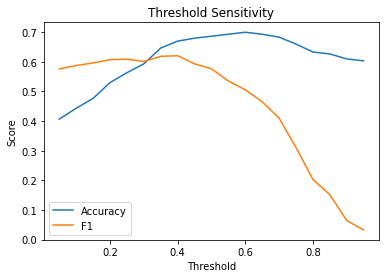

In [46]:
# TODO 2.3: Threshold sweep
thresholds = np.linspace(0.05, 0.95, 19)
rows = []
for t in thresholds:
    preds = (proba >= t).astype(int)
    rows.append({'threshold': t, 'accuracy': (preds == y_test).mean(), 'f1': f1_score(y_test, preds)})
thr_df = pd.DataFrame(rows)
plt.figure()
plt.plot(thr_df['threshold'], thr_df['accuracy'], label='Accuracy')
plt.plot(thr_df['threshold'], thr_df['f1'], label='F1')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Sensitivity')
plt.legend()
plt.show()


In [47]:
# Sanity check 2.4: extreme probability intuition
y_true = np.array([1, 0])
perfect = np.array([0.999, 0.001])
overconfident_wrong = np.array([0.001, 0.999])
print('CE perfect ~ 0:', binary_cross_entropy(y_true, perfect))
print('CE overconfident wrong >>:', binary_cross_entropy(y_true, overconfident_wrong))


CE perfect ~ 0: 0.0010005003335835344
CE overconfident wrong >>: 6.907755278982137


## 3) Interpreting Linear Regression Coefficients (Missed Q12)

**Recap.** Each coefficient is the expected change in the target for a one-unit increase in the feature (others held constant). The intercept is the baseline at zeros.

**Goal.** Recover known coefficients from synthetic data, evaluate fit, and inspect residuals.


In [39]:
# TODO 3.1: Known-coefficients regression
X, y, coef_true = make_regression(n_samples=600, n_features=4, n_informative=4, noise=10.0, coef=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
coef_est = reg.coef_
print('True:', coef_true)
print('Est.:', coef_est)


True: [ 7.55836139 95.14232208 60.36372006  7.69794671]
Est.: [ 7.90193183 95.87058217 61.07841144  7.86819379]


{'MSE': 87.46654205161536, 'R2': 0.9933016628627636}


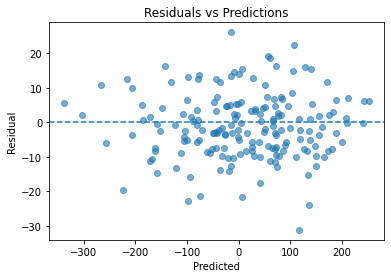

Same sign per feature: [ True  True  True  True]


In [40]:
# TODO 3.2: Fit quality + residuals
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
res = y_test - y_pred
print({'MSE': mse, 'R2': r2})
plt.figure(); plt.scatter(y_pred, res, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residuals vs Predictions')
plt.show()
same_signs = np.sign(coef_true) == np.sign(coef_est)
print('Same sign per feature:', same_signs)
assert same_signs.sum() >= 3, 'At least 3/4 coefficient signs should match.'


## 4) KNN Hyperparameters Deep-Dive (Missed Q14)

**Key hyperparameters.** `n_neighbors`, `metric` (euclidean/manhattan), `weights` (uniform/distance), `algorithm` (auto/brute/kd_tree/ball_tree).

**Goal.** Explore their impact on accuracy and compute time.


In [41]:
# TODO 4.1: Mini hyperparameter sweep
X, y = make_moons(n_samples=1200, noise=0.25, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
scaler = StandardScaler(); X_train_s = scaler.fit_transform(X_train); X_test_s = scaler.transform(X_test)
grid = {
    'n_neighbors': [3, 5, 11, 21],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'brute']
}
results = []
for k in grid['n_neighbors']:
    for m in grid['metric']:
        for w in grid['weights']:
            for alg in grid['algorithm']:
                t0 = time.time()
                clf = KNeighborsClassifier(n_neighbors=k, metric=m, weights=w, algorithm=alg)
                clf.fit(X_train_s, y_train)
                acc = accuracy_score(y_test, clf.predict(X_test_s))
                dt = time.time() - t0
                results.append({'k': k, 'metric': m, 'weights': w, 'algorithm': alg, 'test_acc': acc, 'secs': dt})
hp_df = pd.DataFrame(results).sort_values(['test_acc', 'secs'], ascending=[False, True])
hp_df.head(10)


c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:189: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:189: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

,k,metric,weights,algorithm,test_acc,secs
18,11,euclidean,distance,auto,0.963889,0.004001
30,21,manhattan,distance,auto,0.963889,0.004513
19,11,euclidean,distance,brute,0.963889,0.009997
31,21,manhattan,distance,brute,0.963889,0.010000
20,11,manhattan,uniform,auto,0.963889,0.018003
16,11,euclidean,uniform,auto,0.963889,0.022001
21,11,manhattan,uniform,brute,0.963889,0.022522
17,11,euclidean,uniform,brute,0.963889,0.029513
10,5,euclidean,distance,auto,0.961111,0.002998
26,21,euclidean,distance,auto,0.961111,0.003995


In [42]:
# Sanity check 4.2: ensure at least one good configuration
assert (hp_df['test_acc'] >= 0.75).any(), 'Expected at least one configuration with >= 0.75 accuracy.'
hp_df.iloc[:5]


,k,metric,weights,algorithm,test_acc,secs
18,11,euclidean,distance,auto,0.963889,0.004001
30,21,manhattan,distance,auto,0.963889,0.004513
19,11,euclidean,distance,brute,0.963889,0.009997
31,21,manhattan,distance,brute,0.963889,0.010000
20,11,manhattan,uniform,auto,0.963889,0.018003


---
## 5) Reflection (write ~150 words)

**Prompt:** Summarize what you learned about: (a) KNN bias–variance & hyperparameters, (b) cross-entropy as a probability-sensitive loss, (c) linear regression coefficients. Include one misconception you fixed, one experiment that changed your intuition, and how you’ll explain each concept in an interview.


In [48]:
# TODO 5.1: Your reflection
reflection = """
This workshop deepened my understanding of core machine learning principles and their real-world tradeoffs.
In exploring the **KNN bias–variance** relationship, I learned that choosing the right *k* balances sensitivity a
nd generalization—too small overfits, too large oversmooths. Visualizing both train and validation accuracy clarified 
this intuition. In the **cross-entropy** exercises, I discovered how log loss penalizes overconfident errors, offering a
truer sense of model calibration than raw accuracy. Adjusting classification thresholds demonstrated how metrics like F1 
and accuracy can diverge depending on business priorities. The **linear regression coefficient** section strengthened my
interpretation skills; understanding that each slope quantifies how one feature influences the outcome while holding others 
constant made the model’s transparency clear. Finally, experimenting with **KNN hyperparameters** showed how metrics and algorithms 
affect both performance and runtime. Overall, these exercises made abstract mathematical ideas tangible, preparing me to reason 
confidently during interviews.

"""
print(reflection)



This workshop deepened my understanding of core machine learning principles and their real-world tradeoffs.
In exploring the **KNN bias–variance** relationship, I learned that choosing the right *k* balances sensitivity a
nd generalization—too small overfits, too large oversmooths. Visualizing both train and validation accuracy clarified 
this intuition. In the **cross-entropy** exercises, I discovered how log loss penalizes overconfident errors, offering a
truer sense of model calibration than raw accuracy. Adjusting classification thresholds demonstrated how metrics like F1 
and accuracy can diverge depending on business priorities. The **linear regression coefficient** section strengthened my
interpretation skills; understanding that each slope quantifies how one feature influences the outcome while holding others 
constant made the model’s transparency clear. Finally, experimenting with **KNN hyperparameters** showed how metrics and algorithms 
affect both performance and runtime.

## 6) Sample Reflection (~150 words)

This workshop clarified several interview-critical concepts for me. First, the KNN bias–variance experiments showed why a small k overfits (high variance) and a large k smooths too much (high bias); plotting train vs. validation accuracy made the tradeoff intuitive. The cross-entropy section finally clicked: accuracy ignores probability calibration, while log loss punishes overconfident mistakes—my threshold sweep demonstrated why F1 and log loss can diverge. With linear regression, recovering known coefficients reinforced the interpretation that a coefficient represents the expected change in y for a one-unit change in a feature, holding others constant; the residual plot helped me check assumptions. The KNN hyperparameter grid highlighted practical choices—metric, weights, and neighbor-search algorithm—and their effect on both accuracy and runtime. In an interview, I can now summarize each idea succinctly, justify metric choices with evidence, and reason about tradeoffs rather than relying on defaults. Overall, the sanity checks turned abstract ideas into concrete judgment.
